In [1]:
from __future__ import division

import numpy as np
import os
from glob import glob
import scipy

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd

In [2]:
FURNITURES = ['bed', 'bench', 'chair', 'table']
LAYERS = {'pool1': 0, 'pool2': 1, 'pool3': 2, 'pool4': 3,
          'pool5': 4, 'fc6': 5, 'fc7': 6} # 'prob': 7} taking out probability layer for now. 

LAYERS_NM = ['pool1', 'pool2', 'pool3', 'pool4', 'pool5', 'fc6', 'fc7']


### use vgg19 to extract sketch features

In [3]:
def deactivate(net):
    net.eval()
    for p in net.parameters():
        p.requires_grad = False  
        
use_cuda = torch.cuda.is_available()
cuda_device = 3

vgg19 = models.vgg19(pretrained=True)#.cuda(cuda_device)
vgg19_features = deepcopy(vgg19.features)
vgg19_classifier = deepcopy(vgg19.classifier)

conv1 = nn.Sequential(*(list(vgg19.features.children())[slice(0, 5)]))
conv2 = nn.Sequential(*(list(vgg19.features.children())[slice(5, 10)]))
conv3 = nn.Sequential(*(list(vgg19.features.children())[slice(10, 19)]))
conv4 = nn.Sequential(*(list(vgg19.features.children())[slice(19, 28)]))
conv5 = nn.Sequential(*(list(vgg19.features.children())[slice(28, 37)]))
fc6 = nn.Sequential(*(list(vgg19.classifier.children())[slice(0, 2)]))
fc7 = nn.Sequential(*(list(vgg19.classifier.children())[slice(3, 5)]))
fc8 = nn.Sequential(list(vgg19.classifier.children())[-1])

if use_cuda:
    conv1.cuda(cuda_device)
    conv2.cuda(cuda_device)
    conv3.cuda(cuda_device)
    conv4.cuda(cuda_device)
    conv5.cuda(cuda_device)
    fc6.cuda(cuda_device)    
    fc7.cuda(cuda_device)    
    fc8.cuda(cuda_device)        
        
deactivate(conv1)
deactivate(conv2)
deactivate(conv3)
deactivate(conv4)
deactivate(conv5)
deactivate(fc6)
deactivate(fc7)
deactivate(fc8)

### get sketch data and metadata

In [3]:
# get labels
def list_files(path, ext='png'):
    result = [y for x in os.walk(path)
              for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

def get_label_from_path(path):
    return path.split('.')[-2].split('_')[-1]    

def get_trial_from_path(path):
    return path.split('_')[-2]

def get_subj_from_path(path):
    return path.split('/')[-2]

def get_trial_ID_from_path(path):
    return path.split('/')[-1].split('.')[0]

def get_viewpoint_from_path(path):
    return path.split('_')[3].split('.')[0]
    
# extract metadata
path_to_sketches = '/home/rslee/sketch_data'
sketch_paths = list_files(path_to_sketches)
sketch_labels = map(get_label_from_path,sketch_paths)
trialNum = map(get_trial_from_path,sketch_paths)
subj = map(get_subj_from_path,sketch_paths)
trialID = map(get_trial_ID_from_path, sketch_paths)

path_to_models = '/home/rslee/object_data'
model_paths = list_files(path_to_models, ext='png') 
model_labels = [p.split('/')[-2] for p in model_paths]
model_viewpoints = map(get_viewpoint_from_path, model_paths)


# organize into dataframe
S = pd.DataFrame([subj,trialNum,sketch_labels,sketch_paths, trialID])
S = S.transpose()
S.columns = ['subj','trial','label','path','trialID']


M = pd.DataFrame([model_labels,model_paths, model_viewpoints])
M = M.transpose()
M.columns = ['label','path', 'viewpoint']

print 'Number of sketches: ' + str(len(sketch_paths))
print 'Number of subjects: ' + str(len(np.unique(subj)))


print 'Number of models: ' + str(len(model_paths))
num_models = len(model_paths)
num_sketches = len(sketch_paths)

Number of sketches: 1400
Number of subjects: 35
Number of models: 320


In [5]:
sketch_paths[0]

'/home/rslee/sketch_data/1206161_neurosketch/1206161_neurosketch_trial_335_bench.png'

In [5]:
def load_image(path, imsize=224, volatile=True, use_cuda=False):
    im = Image.open(path)
    im = im.convert('RGB')

    loader = transforms.Compose([
        transforms.Scale(imsize),
        transforms.ToTensor()])

    im = Variable(loader(im), volatile=volatile)
    im = im.unsqueeze(0)
    if use_cuda:
        im = im.cuda(cuda_device)
    return im

def sketch_generator(paths, imsize=224, use_cuda=use_cuda):
    for path in paths:
        sketch = load_image(path)
        label = get_label_from_path(path)
        yield (sketch, label)

def _flatten(x):
    return x.view(x.size(0), -1)
   
def extract_layer(x, layer_index):
    x_conv1 = conv1(x)
    if layer_index == 0:
        return _flatten(x_conv1)
    x_conv2 = conv2(x_conv1)
    if layer_index == 1:
        return _flatten(x_conv2)
    x_conv3 = conv3(x_conv2)
    if layer_index == 2:
        return _flatten(x_conv3)
    x_conv4 = conv4(x_conv3)
    if layer_index == 3:
        return _flatten(x_conv4)
    x_conv5 = conv5(x_conv4)
    x_conv5_flat = _flatten(x_conv5)
    if layer_index == 4:
        return x_conv5_flat
    x_fc6 = fc6(x_conv5_flat)
    if layer_index == 5:
        return x_fc6
    x_fc7 = fc7(x_fc6)
    if layer_index == 6:
        return x_fc7
    x_fc8 = fc8(x_fc7)
    if layer_index == 7:
        return x_fc8
    
def extract_features_and_classes(domain, num_images, layer_index):

    generator = sketch_generator(domain,imsize=224,use_cuda=use_cuda)
    # initialize image and label matrices
    Features = []
    Labels = []
    n = 0
    quit = False 

    # generate batches of imagees and labels    
    if generator:
        while True:    
            batch_size = 62
            image_batch = Variable(torch.zeros(batch_size, 3, 224, 224))
            if use_cuda:
                image_batch = image_batch.cuda(cuda_device)                
            label_batch = []   
            if n%5==0:
                print('Batch {}'.format(n + 1))            
            for b in range(batch_size):
                try:
                    image, label = generator.next()
                    image_batch[b] = image   
                    label_batch.append(label)
                except StopIteration:
                    quit = True
                    print 'stopped!'
                    break                
                
            if n == num_images//batch_size:
                image_batch = image_batch.narrow(0,0,b)
                label_batch = label_batch[:b + 1] 
            n = n + 1       

            # extract features from batch
            image_batch = extract_layer(image_batch, layer_index)                        
            image_batch = image_batch.cpu().data.numpy()

            if len(Features)==0:
                Features = image_batch
            else:
                Features = np.vstack((Features,image_batch))
            Labels.append(label_batch)

            if n == num_images//batch_size + 1:
                break
    Labels = np.array([item for sublist in Labels for item in sublist])
    return Features, Labels

### Visualize feature similarity matrices

In [6]:

MF = []
print('Extracting model features...')

# define layer you want to extract from and do so...
for layer in xrange(0,7):
    print ('Extracting layer ' + str(layer))

    
    MF_i, ML = extract_features_and_classes(model_paths, num_models, layer)
    MF.append(MF_i)

Extracting model features...
Extracting layer 0
Batch 1
Batch 6
stopped!
Extracting layer 1
Batch 1
Batch 6
stopped!
Extracting layer 2
Batch 1
Batch 6
stopped!
Extracting layer 3
Batch 1
Batch 6
stopped!
Extracting layer 4
Batch 1
Batch 6
stopped!
Extracting layer 5
Batch 1
Batch 6
stopped!
Extracting layer 6
Batch 1
Batch 6
stopped!


In [10]:
import pickle

pickle.dump(MF, open( "/tigress/rslee/MF.p", "wb" ) )
pickle.dump(M, open( "/tigress/rslee/M.p", "wb" ) )

In [6]:
SF = []

for layer in xrange(0,7):
    print ('Extracting layer ' + str(layer))
    print('Extracting sketch features...')
    SF_i , SL = extract_features_and_classes(sketch_paths, num_sketches, layer)

    SF.append(SF_i)
    


Extracting layer 0
Extracting sketch features...
Batch 1
Batch 6
Batch 11
Batch 16
Batch 21
stopped!
Extracting layer 1
Extracting sketch features...
Batch 1
Batch 6
Batch 11
Batch 16
Batch 21
stopped!
Extracting layer 2
Extracting sketch features...
Batch 1
Batch 6
Batch 11
Batch 16
Batch 21
stopped!
Extracting layer 3
Extracting sketch features...
Batch 1
Batch 6
Batch 11
Batch 16
Batch 21
stopped!
Extracting layer 4
Extracting sketch features...
Batch 1
Batch 6
Batch 11
Batch 16
Batch 21
stopped!
Extracting layer 5
Extracting sketch features...
Batch 1
Batch 6
Batch 11
Batch 16
Batch 21
stopped!
Extracting layer 6
Extracting sketch features...
Batch 1
Batch 6
Batch 11
Batch 16
Batch 21
stopped!


In [9]:
import pickle
pickle.dump(S, open( "/tigress/rslee/S.p", "wb" ) )


In [10]:
pickle.dump(SF, open( "/tigress/rslee/SF.p", "wb" ) )


In [12]:

## normalize and get means of feature vectors

def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def get_class_means(X, labels):
    # load in and normalize features 
    X = normalize(X)
    _mu = np.zeros((len(np.unique(np.asarray(labels))), X.shape[1]), float)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

_SF = []
for layer in xrange(0,7):
    inds = np.argsort(S.label.values)
    SF_i = SF[layer]
    _SF.append(normalize(SF_i[inds]))
_SL = SL[inds]


In [14]:
for layer in xrange(0,7):
    DF[layer] = normalize(DF[layer])

In [52]:
# plot category-level similarity matrix
RDM_S = []
for layer in xrange(0,7):
    means = get_class_means(_SF[layer], _SL)
    RDM_S.append(np.corrcoef(means))
    
    



In [110]:
RDM_D = []
DL = np.repeat(['bench','chair','table','smart', 'bed', 'limo', 'sedan',  'SUV' ], 40)
for layer in xrange(0,7):

    means = get_class_means(DF[layer], DL)
    means_furn = means[0:4]
    means_furn[-1] = means[4]

    RDM_D.append(np.corrcoef(means_furn))

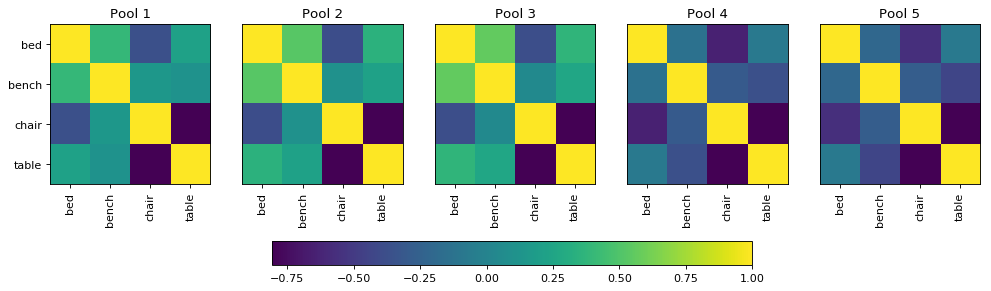

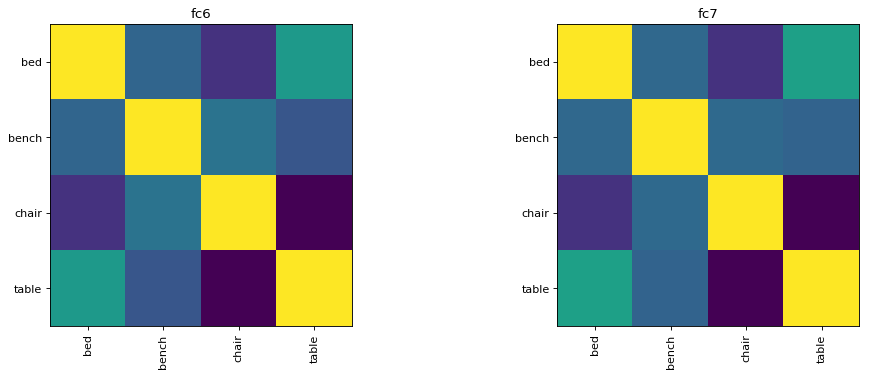

In [17]:
fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')


for pool_layer in xrange(0,5):
    pltname = "Pool " + str(pool_layer + 1)
    plt.subplot(1, 5, pool_layer + 1)
    plt.title(pltname)
    plt.imshow(RDM_S[pool_layer], cmap = 'viridis', interpolation='none')
    plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')
    
    if pool_layer == 0:
        plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)
    else:
        plt.yticks([])
        
        
fig2 = plt.figure(2,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.imshow(RDM_S[5], cmap = 'viridis', interpolation='none')
plt.title("fc6")
plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')
plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)

plt.subplot(122)
plt.imshow(RDM_S[6],cmap = 'viridis', interpolation='none')
plt.title("fc7")
plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')
plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)

cax = fig.add_axes([0.12, 0.1, 0.78, 0.4])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='horizontal', ax=cax)
plt.show()

In [111]:
between_domains = []


for layer in xrange(0,7):
    between_domain_i = np.corrcoef(RDM_S[layer].flatten(), RDM_D[layer].flatten())
    between_domains.append(between_domain_i[0, 1])
    print("pearson coefficient for between domains for layer " + str(layer) + " is " + str(between_domain_i[0, 1]))
    

pearson coefficient for between domains for layer 0 is 0.783104154239
pearson coefficient for between domains for layer 1 is 0.697644835051
pearson coefficient for between domains for layer 2 is 0.656917581733
pearson coefficient for between domains for layer 3 is 0.9104924314
pearson coefficient for between domains for layer 4 is 0.92918192086
pearson coefficient for between domains for layer 5 is 0.917591815446
pearson coefficient for between domains for layer 6 is 0.892298907522


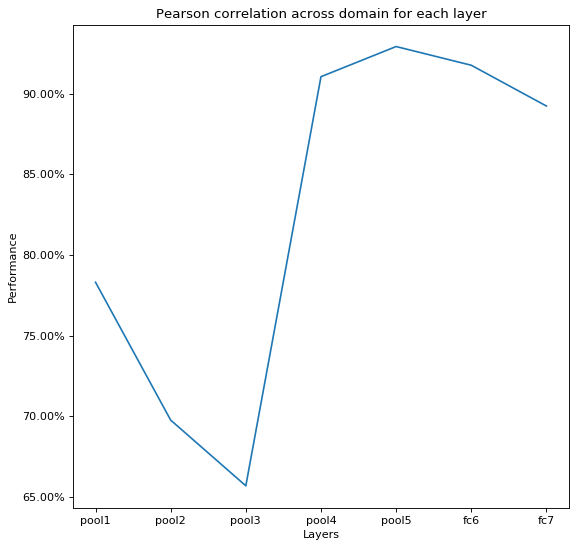

In [112]:
fig = plt.figure(1,  figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')

plt.title("Pearson correlation across domain for each layer")
plt.plot(np.arange(len(LAYERS_NM) ), between_domains)
plt.xlabel('Layers')
plt.ylabel('Performance')



plt.xticks(xrange(0,len(LAYERS) ), LAYERS_NM);
axes = plt.gca()
vals = axes.get_yticks()
axes.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals]);

### Softmax classifier test

In [ ]:
LABELS = _SL
layer_score = []

# compute cross-validated softmax classifier accuracy 
# clf = svm.SVC(kernel='linear', C=1)

for i in reversed(xrange(0,7)):
    clf = linear_model.LogisticRegression(penalty='l2')
    scores = cross_val_score(clf, _SF[i], LABELS, cv=5)

    print("Accuracy for layer %f: %0.2f (+/- %0.2f)" % (i, scores.mean(), scores.std() * 2))
    layer_score.append(scores.mean) 

layer_score = reversed(layer_score)


Accuracy for layer 6.000000: 0.87 (+/- 0.05)
Accuracy for layer 5.000000: 0.88 (+/- 0.06)
Accuracy for layer 4.000000: 0.88 (+/- 0.06)
Accuracy for layer 3.000000: 0.82 (+/- 0.07)
Accuracy for layer 2.000000: 0.79 (+/- 0.09)
Accuracy for layer 1.000000: 0.75 (+/- 0.09)


In [33]:
# single train/test split

for i in reversed(xrange(0,7)):
    
    X_train, X_test, y_train, y_test = train_test_split(
        _SF[i], LABELS, test_size=0.2, random_state=0)
    clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
    print("Score for single trial is %0.2f" % clf.score(X_test, y_test))



Score for single trial is 0.85
Score for single trial is 0.90
Score for single trial is 0.91
Score for single trial is 0.89
Score for single trial is 0.81
Score for single trial is 0.77
Score for single trial is 0.70
